# Recommender System and Customer Segmentation on Purhasing Customer

**Author**: Moch Nabil Farras Dhiya

**E-mail**: nabilfarras923@gmail.com

**Institution**: Bandung Institute of Technology

**Student ID**: 10120034


---

**About**: This is a side-project created in order to build a recommendation system for users as well as segmenting the users based on an e-commerce transactional data by the following steps:

1.   Extract the data from Kaggle website
2.   Transform the data (making sure it is usable and consistent)
3.   Make a Recommendation System model using Turicreate (Source: [Medium by Moorissa Tjokro](https://medium.datadriveninvestor.com/how-to-build-a-recommendation-system-for-purchase-data-step-by-step-d6d7a78800b6)
4.   Segmenting the products and customers using WordCloud and Clustering based on the transaction histories
5.   Deploy the Recommendation System Pipeline with Flask.

# Import Modules

In [1]:
!pip install turicreate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Connect to local
import os

# Importing and transforming file
import pandas as pd

# Data manipulation
import numpy as np
import re # Cleaning texts
import datetime as dt # Datetime manipulation

# Modeling
from sklearn.model_selection import train_test_split
import turicreate as tc

# Clustering
from sklearn.preprocessing import StandardScaler, LabelEncoder # Scaling, Label Encoding
from sklearn.cluster import KMeans, AgglomerativeClustering # Clustering
from sklearn.decomposition import PCA # Dimensionality Reduction
from yellowbrick.cluster import KElbowVisualizer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from wordcloud import WordCloud, STOPWORDS

sns.set_theme(palette = 'deep')
sns.set(rc = {'figure.figsize': (8, 6)})

# Import Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/RecSys

/content/drive/MyDrive/RecSys


In [5]:
data = pd.read_csv('data.csv', encoding = 'unicode_escape')

In [6]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


# Feature Engineering

Notice that the InvoiceDate column contains the date and time of the transaction. We will **split** the information into **2 different columns (Date and Time)** to make it easier to gain insight and build the model later on.

In [7]:
# Extract the time
data['InvoiceTime'] = data['InvoiceDate'].apply(lambda x: x.split()[1])

# Extract the date
data['InvoiceDate'] = data['InvoiceDate'].apply(lambda x: x.split()[0])
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format = '%m/%d/%Y')

In [8]:
data = data[['InvoiceNo', 'InvoiceDate', 'InvoiceTime', 'CustomerID', 'Country',
             'StockCode', 'Description', 'Quantity', 'UnitPrice']]

data

,InvoiceNo,InvoiceDate,InvoiceTime,CustomerID,Country,StockCode,Description,Quantity,UnitPrice
0,536365,2010-12-01,8:26,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55
1,536365,2010-12-01,8:26,17850.0,United Kingdom,71053,WHITE METAL LANTERN,6,3.39
2,536365,2010-12-01,8:26,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75
3,536365,2010-12-01,8:26,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39
4,536365,2010-12-01,8:26,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39
...,...,...,...,...,...,...,...,...,...
541904,581587,2011-12-09,12:50,12680.0,France,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85
541905,581587,2011-12-09,12:50,12680.0,France,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10
541906,581587,2011-12-09,12:50,12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15
541907,581587,2011-12-09,12:50,12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15


# Initial EDA

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   InvoiceDate  541909 non-null  datetime64[ns]
 2   InvoiceTime  541909 non-null  object        
 3   CustomerID   406829 non-null  float64       
 4   Country      541909 non-null  object        
 5   StockCode    541909 non-null  object        
 6   Description  540455 non-null  object        
 7   Quantity     541909 non-null  int64         
 8   UnitPrice    541909 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 37.2+ MB


In [10]:
for col in data.columns:
    print(f'========== {col} ==========')
    display(data[col].value_counts())

========== InvoiceNo ==========


573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
554023        1
554022        1
554021        1
554020        1
C558901       1
Name: InvoiceNo, Length: 25900, dtype: int64

========== InvoiceDate ==========


2011-12-05    5331
2011-12-08    4940
2011-11-29    4313
2011-11-16    4195
2011-11-11    4089
              ... 
2011-03-13     537
2010-12-19     522
2011-05-01     452
2010-12-22     291
2011-02-06     279
Name: InvoiceDate, Length: 305, dtype: int64

========== InvoiceTime ==========


15:56    2628
14:41    2554
15:17    2376
16:14    2372
14:09    2172
         ... 
6:14        1
6:13        1
6:12        1
20:32       1
6:21        1
Name: InvoiceTime, Length: 774, dtype: int64

========== CustomerID ==========


17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
15070.0       1
15753.0       1
17065.0       1
16881.0       1
16995.0       1
Name: CustomerID, Length: 4372, dtype: int64

========== Country ==========


United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

========== StockCode ==========


85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64

========== Description ==========


WHITE HANGING HEART T-LIGHT HOLDER     2369
REGENCY CAKESTAND 3 TIER               2200
JUMBO BAG RED RETROSPOT                2159
PARTY BUNTING                          1727
LUNCH BAG RED RETROSPOT                1638
                                       ... 
Missing                                   1
historic computer difference?....se       1
DUSTY PINK CHRISTMAS TREE 30CM            1
WRAP BLUE RUSSIAN FOLKART                 1
PINK BERTIE MOBILE PHONE CHARM            1
Name: Description, Length: 4223, dtype: int64

========== Quantity ==========


 1        148227
 2         81829
 12        61063
 6         40868
 4         38484
           ...  
-472           1
-161           1
-1206          1
-272           1
-80995         1
Name: Quantity, Length: 722, dtype: int64

========== UnitPrice ==========


1.25      50496
1.65      38181
0.85      28497
2.95      27768
0.42      24533
          ...  
84.21         1
46.86         1
28.66         1
156.45        1
224.69        1
Name: UnitPrice, Length: 1630, dtype: int64

In [11]:
data['CustomerID'] = data['CustomerID'].astype('str')

In [12]:
# Split the columns into 2 type, namely object and numeric columns
object_cols = [col for col in data.columns if data[col].dtypes in ['object', 'datetime64[ns]']]
numeric_cols = [col for col in data.columns if col not in object_cols]

## Object Columns

In [13]:
data[object_cols].describe().transpose()

<ipython-input-13-e30c49c35305>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data[object_cols].describe().transpose()


,count,unique,top,freq,first,last
InvoiceNo,541909,25900,573585,1114,NaT,NaT
InvoiceDate,541909,305,2011-12-05 00:00:00,5331,2010-12-01,2011-12-09
InvoiceTime,541909,774,15:56,2628,NaT,NaT
CustomerID,541909,4373,nan,135080,NaT,NaT
Country,541909,38,United Kingdom,495478,NaT,NaT
StockCode,541909,4070,85123A,2313,NaT,NaT
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaT,NaT


## Numeric Columns

In [14]:
data[numeric_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0


# Data Cleaning & Manipulation

Notice that there are several entries which StockCode are unusual. Thus, we will drop these entries.

In [15]:
data = data.loc[(data['StockCode'] != 'BANK CHARGES') &
                (data['StockCode'] != 'C2') &
                (data['StockCode'] != 'CRUK') &
                (data['StockCode'] != 'D') &
                (data['StockCode'] != 'DOT') &
                (data['StockCode'] != 'M') &
                (data['StockCode'] != 'PADS') &
                (data['StockCode'] != 'POST') &
                (data['StockCode'] != 'AMAZONFEE') &
                (data['StockCode'] != 'B') &
                (data['StockCode'] != 'S') &
                (data['StockCode'] != 'm') &
                (data['StockCode'] != 'gift_0001_10') &
                (data['StockCode'] != 'gift_0001_20') &
                (data['StockCode'] != 'gift_0001_30') &
                (data['StockCode'] != 'gift_0001_40') &
                (data['StockCode'] != 'gift_0001_50')]

We will also check just in case there are entries with negative values. We will drop these entries.

In [16]:
data = data[data[numeric_cols].ge(0).all(1)].reset_index(drop = True)

data

,InvoiceNo,InvoiceDate,InvoiceTime,CustomerID,Country,StockCode,Description,Quantity,UnitPrice
0,536365,2010-12-01,8:26,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55
1,536365,2010-12-01,8:26,17850.0,United Kingdom,71053,WHITE METAL LANTERN,6,3.39
2,536365,2010-12-01,8:26,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75
3,536365,2010-12-01,8:26,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39
4,536365,2010-12-01,8:26,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39
...,...,...,...,...,...,...,...,...,...
528914,581587,2011-12-09,12:50,12680.0,France,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85
528915,581587,2011-12-09,12:50,12680.0,France,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10
528916,581587,2011-12-09,12:50,12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15
528917,581587,2011-12-09,12:50,12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15


In addition to that, we will also try to reduce the number of rows by performing aggregation on the quantity transaction, if the same transaction were to occur in the same time, but recorded differently (whether the quantity is the same or different).

In [17]:
data['TotalQuantity'] = data.groupby(['InvoiceNo', 'InvoiceDate', 'InvoiceTime',
                                      'CustomerID', 'Country', 'StockCode', 'Description', 
                                      'UnitPrice'])['Quantity'].transform('sum')

data = data[['InvoiceNo', 'InvoiceDate', 'InvoiceTime',
             'CustomerID', 'Country', 'StockCode', 'Description', 
             'TotalQuantity', 'UnitPrice']]

# Missing Value(s) Handling 

In [18]:
missing_pct = []

for col in data.columns:
    missing = data[col].isnull().sum()
    missing_pct.append(100 * missing/len(data))
    
missing_df = pd.DataFrame({'Column': data.columns,
                           'Missing Percentage': missing_pct})
missing_df

,Column,Missing Percentage
0,InvoiceNo,0.000000
1,InvoiceDate,0.000000
2,InvoiceTime,0.000000
3,CustomerID,0.000000
4,Country,0.000000
5,StockCode,0.000000
6,Description,0.110414
7,TotalQuantity,0.110414
8,UnitPrice,0.000000


In [19]:
data.loc[data['Description'].isna()]

,InvoiceNo,InvoiceDate,InvoiceTime,CustomerID,Country,StockCode,Description,TotalQuantity,UnitPrice
611,536414,2010-12-01,11:52,nan,United Kingdom,22139,NaN,NaN,0.0
1953,536545,2010-12-01,14:32,nan,United Kingdom,21134,NaN,NaN,0.0
1954,536546,2010-12-01,14:33,nan,United Kingdom,22145,NaN,NaN,0.0
1955,536547,2010-12-01,14:33,nan,United Kingdom,37509,NaN,NaN,0.0
1956,536549,2010-12-01,14:34,nan,United Kingdom,85226A,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...
520857,581103,2011-12-07,11:58,nan,United Kingdom,22689,NaN,NaN,0.0
522436,581203,2011-12-07,18:31,nan,United Kingdom,23406,NaN,NaN,0.0
522437,581209,2011-12-07,18:35,nan,United Kingdom,21620,NaN,NaN,0.0
524062,581234,2011-12-08,10:33,nan,United Kingdom,72817,NaN,NaN,0.0


In [20]:
len(data.loc[data['CustomerID'] == 'nan'])/len(data)

0.2506035895855509

Notice that there are several missing values in our data. But, since the missing values are in the essential info (CustomerID), we will then drop these data, even though the missing percentage is quite large (~25 %)

In [21]:
data = data.loc[data['CustomerID'] != 'nan']

data.isna().sum()

InvoiceNo        0
InvoiceDate      0
InvoiceTime      0
CustomerID       0
Country          0
StockCode        0
Description      0
TotalQuantity    0
UnitPrice        0
dtype: int64

# Duplicate Value(s) Handling 

In [22]:
print(f'Missing value percentage: {100 - 100 * len(data.drop_duplicates()) / len(data)} %')

Missing value percentage: 2.5070010343870592 %


Since the missing value percentage is not 0 %, then there must be duplicate entries recorded in the dataset.

In [23]:
data[data.duplicated(keep = False) == True]

,InvoiceNo,InvoiceDate,InvoiceTime,CustomerID,Country,StockCode,Description,TotalQuantity,UnitPrice
112,536381,2010-12-01,9:41,15311.0,United Kingdom,71270,PHOTO CLIP LINE,4.0,1.25
124,536381,2010-12-01,9:41,15311.0,United Kingdom,71270,PHOTO CLIP LINE,4.0,1.25
472,536409,2010-12-01,11:45,17908.0,United Kingdom,90199C,5 STRAND GLASS NECKLACE CRYSTAL,6.0,6.35
474,536409,2010-12-01,11:45,17908.0,United Kingdom,22111,SCOTTIE DOG HOT WATER BOTTLE,2.0,4.95
478,536409,2010-12-01,11:45,17908.0,United Kingdom,22866,HAND WARMER SCOTTY DOG DESIGN,2.0,2.10
...,...,...,...,...,...,...,...,...,...
528708,581538,2011-12-09,11:34,14446.0,United Kingdom,22992,REVOLVER WOODEN RULER,2.0,1.95
528713,581538,2011-12-09,11:34,14446.0,United Kingdom,21194,PINK HONEYCOMB PAPER FAN,3.0,0.65
528714,581538,2011-12-09,11:34,14446.0,United Kingdom,35004B,SET OF 3 BLACK FLYING DUCKS,3.0,5.45
528715,581538,2011-12-09,11:34,14446.0,United Kingdom,22694,WICKER STAR,2.0,2.10


Notice that it does not make sense for a transaction to be recorded more than once (at the same Invoice Date and Time). Thus, we will simply drop the duplicate entries.

**Note**: This may occur because of the aggregation performed in the previous section (Data Cleaning & Manipulation).

In [24]:
data = data.drop_duplicates().reset_index(drop = True)

In [25]:
print(f'Missing value percentage: {100 - 100 * len(data.drop_duplicates()) / len(data)} %')

Missing value percentage: 0.0 %


# Recommendation System

Here, we will build 2 different models, namely Customer-Based and Item-Based Recommendation System.

## Data Preparation

We will use 2 different data, which is Data 1 and Data 2.

**Data 1**: Aggregating by a customer' purchase count on a certain product

**Data 2**: Binary input whether a customer already purchased certain product or not

### Encoding

In [26]:
le_customer = LabelEncoder()
le_customer.fit(data['CustomerID'])
le_customer_mapping = dict(zip(le_customer.classes_, le_customer.transform(le_customer.classes_)))

le_stock = LabelEncoder()
le_stock.fit(data['StockCode'])
le_stock_mapping = dict(zip(le_stock.classes_, le_stock.transform(le_stock.classes_)))

In [27]:
customer_data = pd.DataFrame()
customer_data['CustomerID'] = le_customer_mapping.keys()
customer_data['Encoder'] = le_customer_mapping.values()

stock_data = pd.DataFrame()
stock_data['StockCode'] = le_stock_mapping.keys()
stock_data['Encoder'] = le_stock_mapping.values()

In [28]:
data['CustomerID'] = le_customer.transform(data['CustomerID'])
data['StockID'] = le_stock.transform(data['StockCode'])

### Save Data

In [29]:
data.to_csv('transactions_data.csv')
customer_data.to_csv('customers_data.csv')
stock_data.to_csv('stocks_data.csv')

In [30]:
customer_item_matrix = data.pivot_table(index = 'CustomerID', 
                                        columns = 'StockID', 
                                        values = 'TotalQuantity',
                                        aggfunc = 'count')

### Data 1

In [31]:
# Customer-Item Matrix by Count Aggregate
purchase_matrix = customer_item_matrix.applymap(lambda x: x if x > 0 else 0)

purchase_matrix

StockID,0,1,2,3,4,5,6,7,8,9,...,3649,3650,3651,3652,3653,3654,3655,3656,3657,3658
CustomerID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
stock_codes = purchase_matrix.columns
temp_purchase = purchase_matrix.reset_index()

purchase_data = pd.melt(temp_purchase, id_vars = 'CustomerID', value_vars = stock_codes)
purchase_data = purchase_data.loc[purchase_data['value'] > 0].reset_index(drop = True)
purchase_data

,CustomerID,StockID,value
0,86,0,1.0
1,130,0,1.0
2,189,0,1.0
3,235,0,1.0
4,266,0,1.0
...,...,...,...
266221,1067,3656,1.0
266222,1067,3657,1.0
266223,1643,3657,1.0
266224,1662,3657,1.0


In [33]:
purchase_data.to_csv('purchase_data.csv')

### Data 2

In [34]:
# Customer-Item Matrix by Binary Input
binary_matrix = customer_item_matrix.applymap(lambda x: 1 if x > 0 else 0)

binary_matrix

StockID,0,1,2,3,4,5,6,7,8,9,...,3649,3650,3651,3652,3653,3654,3655,3656,3657,3658
CustomerID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4330,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
stock_codes = binary_matrix.columns
temp_binary = binary_matrix.reset_index()

binary_data = pd.melt(temp_binary, id_vars = 'CustomerID', value_vars = stock_codes)
binary_data = binary_data.loc[binary_data['value'] > 0].reset_index(drop = True)
binary_data

,CustomerID,StockID,value
0,86,0,1
1,130,0,1
2,189,0,1
3,235,0,1
4,266,0,1
...,...,...,...
266221,1067,3656,1
266222,1067,3657,1
266223,1643,3657,1
266224,1662,3657,1


In [36]:
binary_data.to_csv('binary_data.csv')

### Train Test Split

In [37]:
def data_split(df):
    train, test = train_test_split(df, test_size = 0.25)
    train_data = tc.SFrame(train)
    test_data = tc.SFrame(test)

    return train_data, test_data

In [38]:
# Split the data
train_purchase, test_purchase = data_split(purchase_data)
train_binary, test_binary = data_split(binary_data)

## Modeling

In [39]:
# Constant variables to define field names include:
users_id = 'CustomerID'
items_id = 'StockID'
targets = 'value'
users_to_recommend = list(set(data[users_id]))
n_rec = 10 # number of items to recommend
n_display = 30 # to display the first few rows in an output dataset

### Customer-Based

In [40]:
def customer_sim_model(train_data, name, users_id, items_id, targets, users_to_recommend, n_rec, n_display):
    if name == 'cosine':
        model = tc.item_similarity_recommender.create(train_data, 
                                                      user_id = users_id, 
                                                      item_id = items_id, 
                                                      target = targets, 
                                                      similarity_type = 'cosine')
    elif name == 'pearson':
        model = tc.item_similarity_recommender.create(train_data, 
                                                      user_id = users_id, 
                                                      item_id = items_id, 
                                                      target = targets, 
                                                      similarity_type = 'pearson')
        
    recom = model.recommend(users = users_to_recommend, 
                            k = n_rec)
    recom.print_rows(n_display)

    return model

In [41]:
train_binary.column_types()

[int, int, int]

Cosine Similarity

In [42]:
# Aggregate Purchase Count
name = 'cosine'
cos_purchase = customer_sim_model(train_purchase, name, users_id, items_id, targets, users_to_recommend, n_rec, n_display)

cos_purchase

Preparing data set.

Data has 199669 observations with 4306 users and 3607 items.

Data prepared in: 0.211532s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 5.287ms                        | 23         |

| 21.563ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 112.671ms                           | 0                | 1               |

| 816.689ms                           | 100              | 3607            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.84899s

recommendations finished on 1000/4335 queries. users per second: 16321.2

recommendations finished on 2000/4335 queries. users per second: 16525.9

recommendations finished on 3000/4335 queries. users per second: 16444.4

recommendations finished on 4000/4335 queries. users per second: 16070.5

+------------+---------+----------------------+------+
| CustomerID | StockID |        score         | rank |
+------------+---------+----------------------+------+
|     0      |   423   | 0.03958353996276855  |  1   |
|     0      |   170   | 0.027501212358474733 |  2   |
|     0      |   2032  | 0.027147806882858276 |  3   |
|     0      |   1253  | 0.026447142362594604 |  4   |
|     0      |   2001  | 0.026370540857315064 |  5   |
|     0      |   1288  | 0.025491312742233277 |  6   |
|     0      |   2029  | 0.024042845964431764 |  7   |
|     0      |   2116  | 0.02338672637939453  |  8   |
|     0      |   1255  |  0.0231551468372345  |  9   |
|     0      |   1256  | 0.023043773174285888 |  10  |
|     1      |   423   |  0.257036593053248   |  1   |
|     1      |   908   | 0.23927829172704126  |  2   |
|     1      |   141   | 0.22694438541090334  |  3   |
|     1      |   3565  | 0.22694438541090334  |  4   |
|     1      |   3549  | 0.22694438541090334  |  5   |
|     1   

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : CustomerID
Item ID                          : StockID
Target                           : value
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 199669
Number of users                  : 4306
Number of items                  : 3607

Training summary
----------------
Training time                    : 1.849

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : cosine
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size               :

In [43]:
# Binary Input
name = 'cosine'
cos_binary = customer_sim_model(train_binary, name, users_id, items_id, targets, users_to_recommend, n_rec, n_display)

cos_binary

Preparing data set.

Data has 199669 observations with 4309 users and 3599 items.

Data prepared in: 0.207s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 12.841ms                       | 23         |

| 26.032ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 124.871ms                           | 0                | 2               |

| 769.513ms                           | 100              | 3599            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.812626s

recommendations finished on 1000/4335 queries. users per second: 11847.1

recommendations finished on 2000/4335 queries. users per second: 13641.1

recommendations finished on 3000/4335 queries. users per second: 14470.5

recommendations finished on 4000/4335 queries. users per second: 14599.3

+------------+---------+----------------------+------+
| CustomerID | StockID |        score         | rank |
+------------+---------+----------------------+------+
|     0      |   1996  | 0.48970693349838257  |  1   |
|     0      |   1998  | 0.48600250482559204  |  2   |
|     0      |   1802  | 0.21285563707351685  |  3   |
|     0      |   1834  |  0.1984320878982544  |  4   |
|     0      |   1516  |  0.1972861886024475  |  5   |
|     0      |   2124  | 0.19226843118667603  |  6   |
|     0      |   1570  | 0.18619829416275024  |  7   |
|     0      |   2066  | 0.18545126914978027  |  8   |
|     0      |   2004  |  0.185167133808136   |  9   |
|     0      |   1820  | 0.18461376428604126  |  10  |
|     1      |   1807  | 0.052382120960637144 |  1   |
|     1      |   2006  | 0.04971658242376227  |  2   |
|     1      |   423   | 0.048686016547052485 |  3   |
|     1      |   1288  | 0.044095548359971294 |  4   |
|     1      |   2075  | 0.04171246133352581  |  5   |
|     1   

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : CustomerID
Item ID                          : StockID
Target                           : value
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 199669
Number of users                  : 4309
Number of items                  : 3599

Training summary
----------------
Training time                    : 0.8127

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : cosine
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size               

Pearson Similarity

In [44]:
# Aggregate Purchase Count
name = 'pearson'
pear_purchase = customer_sim_model(train_purchase, name, users_id, items_id, targets, users_to_recommend, n_rec, n_display)

pear_purchase

Preparing data set.

Data has 199669 observations with 4306 users and 3607 items.

Data prepared in: 0.226051s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 14.803ms                       | 23         |

| 34.446ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 51.152ms                            | 0                | 1               |

| 820.642ms                           | 100              | 3607            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.8544s

recommendations finished on 1000/4335 queries. users per second: 12832.5

recommendations finished on 2000/4335 queries. users per second: 13983.9

recommendations finished on 3000/4335 queries. users per second: 14352.2

recommendations finished on 4000/4335 queries. users per second: 13718.9

+------------+---------+--------------------+------+
| CustomerID | StockID |       score        | rank |
+------------+---------+--------------------+------+
|     0      |   3246  |        6.5         |  1   |
|     0      |   2863  |        5.5         |  2   |
|     0      |   3473  |        5.0         |  3   |
|     0      |   2578  | 3.5776333174338704 |  4   |
|     0      |    96   |        3.0         |  5   |
|     0      |   2806  |        3.0         |  6   |
|     0      |   717   |        2.8         |  7   |
|     0      |   884   | 2.761879051129024  |  8   |
|     0      |   3635  |        2.75        |  9   |
|     0      |   3248  |        2.75        |  10  |
|     1      |   3246  |        6.5         |  1   |
|     1      |   2863  |  5.50049603217608  |  2   |
|     1      |   3473  |        5.0         |  3   |
|     1      |   2578  | 3.5909666112371967 |  4   |
|     1      |   2806  | 3.0015643958921556 |  5   |
|     1      |    96   |        3.0         | 

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : CustomerID
Item ID                          : StockID
Target                           : value
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 199669
Number of users                  : 4306
Number of items                  : 3607

Training summary
----------------
Training time                    : 0.8545

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : pearson
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size              

In [45]:
# Binary Input
name = 'pearson'
pear_binary = customer_sim_model(train_binary, name, users_id, items_id, targets, users_to_recommend, n_rec, n_display)

pear_binary

Preparing data set.

Data has 199669 observations with 4309 users and 3599 items.

Data prepared in: 0.223013s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 14.003ms                       | 23         |

| 33.098ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 49.996ms                            | 0                | 2               |

| 751.295ms                           | 100              | 3599            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.786393s

recommendations finished on 1000/4335 queries. users per second: 16540.7

recommendations finished on 2000/4335 queries. users per second: 16220.5

recommendations finished on 3000/4335 queries. users per second: 16544.1

recommendations finished on 4000/4335 queries. users per second: 16518.3

+------------+---------+-------+------+
| CustomerID | StockID | score | rank |
+------------+---------+-------+------+
|     0      |   390   |  0.0  |  1   |
|     0      |   784   |  0.0  |  2   |
|     0      |   2134  |  0.0  |  3   |
|     0      |   2618  |  0.0  |  4   |
|     0      |   1220  |  0.0  |  5   |
|     0      |   1412  |  0.0  |  6   |
|     0      |   1450  |  0.0  |  7   |
|     0      |   1416  |  0.0  |  8   |
|     0      |   1227  |  0.0  |  9   |
|     0      |   1746  |  0.0  |  10  |
|     1      |   390   |  0.0  |  1   |
|     1      |   784   |  0.0  |  2   |
|     1      |   2134  |  0.0  |  3   |
|     1      |   2618  |  0.0  |  4   |
|     1      |   1220  |  0.0  |  5   |
|     1      |   1412  |  0.0  |  6   |
|     1      |   1450  |  0.0  |  7   |
|     1      |   1416  |  0.0  |  8   |
|     1      |   1227  |  0.0  |  9   |
|     1      |   1746  |  0.0  |  10  |
|     2      |   390   |  0.0  |  1   |
|     2      |   784   |  0.0  |  2   |


Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : CustomerID
Item ID                          : StockID
Target                           : value
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 199669
Number of users                  : 4309
Number of items                  : 3599

Training summary
----------------
Training time                    : 0.7864

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : pearson
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size              

### Item-Based

In [46]:
def item_pop_model(train_data, name, users_id, items_id, targets, users_to_recommend, n_rec, n_display):
    model = tc.item_similarity_recommender.create(train_data, 
                                                  user_id = users_id, 
                                                  item_id = items_id, 
                                                  target = targets)
        
    recom = model.recommend(users = users_to_recommend, 
                            k = n_rec)
    recom.print_rows(n_display)

    return model

In [47]:
# Aggregate Purchase Count
item_purchase = item_pop_model(train_purchase, name, users_id, items_id, targets, users_to_recommend, n_rec, n_display)

item_purchase

Preparing data set.

Data has 199669 observations with 4306 users and 3607 items.

Data prepared in: 0.21416s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 6.606ms                        | 23         |

| 15.001ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 22.121ms                            | 0                | 1               |

| 683.962ms                           | 100              | 3607            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.717107s

recommendations finished on 1000/4335 queries. users per second: 16090.1

recommendations finished on 2000/4335 queries. users per second: 13547

recommendations finished on 3000/4335 queries. users per second: 13910.2

recommendations finished on 4000/4335 queries. users per second: 13880.5

+------------+---------+----------------------+------+
| CustomerID | StockID |        score         | rank |
+------------+---------+----------------------+------+
|     0      |   170   | 0.11191058516502381  |  1   |
|     0      |   173   | 0.10742870569229127  |  2   |
|     0      |   1253  | 0.10637876987457276  |  3   |
|     0      |   2033  | 0.09699493050575256  |  4   |
|     0      |   2039  | 0.09691735148429871  |  5   |
|     0      |   1255  | 0.09511887550354003  |  6   |
|     0      |   2037  | 0.09391719460487366  |  7   |
|     0      |   172   |  0.0880121648311615  |  8   |
|     0      |   423   | 0.08675335049629211  |  9   |
|     0      |   3219  | 0.08632219314575196  |  10  |
|     1      |   2005  | 0.03139762367521014  |  1   |
|     1      |   1547  | 0.02921198018185504  |  2   |
|     1      |   2125  |  0.0253557005485931  |  3   |
|     1      |   2003  | 0.024639368057250977 |  4   |
|     1      |   910   | 0.022352083162827927 |  5   |
|     1   

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : CustomerID
Item ID                          : StockID
Target                           : value
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 199669
Number of users                  : 4306
Number of items                  : 3607

Training summary
----------------
Training time                    : 0.7172

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : jaccard
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size              

In [48]:
# Binary Input
item_binary = item_pop_model(train_binary, name, users_id, items_id, targets, users_to_recommend, n_rec, n_display)

item_binary

Preparing data set.

Data has 199669 observations with 4309 users and 3599 items.

Data prepared in: 0.188215s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 5.773ms                        | 23         |

| 12.349ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 21.406ms                            | 0                | 2               |

| 653.252ms                           | 100              | 3599            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.682608s

recommendations finished on 1000/4335 queries. users per second: 15389.1

recommendations finished on 2000/4335 queries. users per second: 14785.8

recommendations finished on 3000/4335 queries. users per second: 15376.1

recommendations finished on 4000/4335 queries. users per second: 15212.9

+------------+---------+----------------------+------+
| CustomerID | StockID |        score         | rank |
+------------+---------+----------------------+------+
|     0      |   1996  |  0.3235294222831726  |  1   |
|     0      |   1998  | 0.32098764181137085  |  2   |
|     0      |   2124  | 0.10550457239151001  |  3   |
|     0      |   2066  | 0.10000002384185791  |  4   |
|     0      |   1820  | 0.09842520952224731  |  5   |
|     0      |   2004  | 0.09774434566497803  |  6   |
|     0      |   1802  |  0.0959821343421936  |  7   |
|     0      |   2028  |  0.0948905348777771  |  8   |
|     0      |   2072  |       0.09375        |  9   |
|     0      |   2126  | 0.09349590539932251  |  10  |
|     1      |   2006  | 0.03177801950981742  |  1   |
|     1      |   2003  | 0.025435602194384524 |  2   |
|     1      |   1807  | 0.024311540158171403 |  3   |
|     1      |   1547  | 0.024073612533117596 |  4   |
|     1      |   2075  | 0.020966831790773494 |  5   |
|     1   

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : CustomerID
Item ID                          : StockID
Target                           : value
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 199669
Number of users                  : 4309
Number of items                  : 3599

Training summary
----------------
Training time                    : 0.6827

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : jaccard
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size              

## Evaluation

Now, we will evaluate our models by seeing the similarities between certain customer and the other customers based on these Recommendation System models to see which model is the best.

In [49]:
purchase_models = [item_purchase, cos_purchase, pear_purchase]
binary_models = [item_binary, cos_binary, pear_binary]

purchase_names = ['Popularity Model on Purchase Counts', 'Cosine Similarity on Purchase Counts', 'Pearson Similarity on Purchase Counts']
binary_names = ['Popularity Model on Purchase Dummy', 'Cosine Similarity on Purchase Dummy', 'Pearson Similarity on Purchase Dummy']

In [50]:
purchase_eval = tc.recommender.util.compare_models(test_purchase, 
                                                   purchase_models, 
                                                   model_names = purchase_names)

purchase_eval

PROGRESS: Evaluate model Popularity Model on Purchase Counts


recommendations finished on 1000/4131 queries. users per second: 10305.8

recommendations finished on 2000/4131 queries. users per second: 11108.7

recommendations finished on 3000/4131 queries. users per second: 11365.7

recommendations finished on 4000/4131 queries. users per second: 11549.8


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.27063664972161683 | 0.03616942043884065 |
|   2    | 0.24267731784071653 | 0.06076839099112299 |
|   3    | 0.22052771725974354 | 0.07988414890840376 |
|   4    | 0.20533769063180832 |  0.0970649494718677 |
|   5    | 0.19220527717259706 | 0.10872348565205402 |
|   6    | 0.18042443314774478 | 0.11985070998658179 |
|   7    |  0.1714908185496421 | 0.13024475354915396 |
|   8    |  0.1633684337932704 |  0.1389252588763411 |
|   9    | 0.15619032249388104 | 0.14667094050408175 |
|   10   | 0.15003631082062435 | 0.15520267932159496 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.9482563292039212

Per User RMSE (best)
+------------+--------------------+-------+
| CustomerID |        rmse        | count |
+-----------

recommendations finished on 1000/4131 queries. users per second: 10915.5

recommendations finished on 2000/4131 queries. users per second: 10513.1

recommendations finished on 3000/4131 queries. users per second: 10775.9

recommendations finished on 4000/4131 queries. users per second: 10876.7


Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+----------------------+
|   1    |  0.1082062454611474  | 0.016510278990759693 |
|   2    | 0.09162430404260476  | 0.025213310182972567 |
|   3    |  0.0806100217864924  | 0.03217465931475017  |
|   4    | 0.07328733962720892  | 0.03870457828820343  |
|   5    | 0.06618252239167263  | 0.04278994260610864  |
|   6    | 0.06188977648672641  | 0.04775450826097341  |
|   7    | 0.057198187917141964 | 0.05097186457423884  |
|   8    | 0.054193899782135076 | 0.05460049200891246  |
|   9    |  0.0514537776701904  | 0.05716523845883243  |
|   10   | 0.04848704914064384  | 0.059280199941975385 |
+--------+----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.9248184281767438

Per User RMSE (best)
+------------+--------------------+-------+
| CustomerID |        rmse  

recommendations finished on 1000/4131 queries. users per second: 10005.1

recommendations finished on 2000/4131 queries. users per second: 10500.4

recommendations finished on 3000/4131 queries. users per second: 10062.7

recommendations finished on 4000/4131 queries. users per second: 10116.3


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    |          0.0          |          0.0           |
|   2    | 0.0010893246187363838 |  0.000201477064376976  |
|   3    | 0.0007262164124909221 | 0.00020147706437697598 |
|   4    |  0.000786734446865166 | 0.0002313727350978745  |
|   5    | 0.0007262164124909226 | 0.0002630726578653354  |
|   6    | 0.0006858710562414263 | 0.00030271020084729597 |
|   7    | 0.0010028702839160345 | 0.0004554278462022424  |
|   8    | 0.0010288065843621402 | 0.0005846612156274683  |
|   9    |  0.001048979262486886 | 0.0006165968958661103  |
|   10   | 0.0010893246187363838 | 0.0007550449022869083  |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 1.2844426474964432

Per User RMSE (best)
+------------+------+-------+


[{'precision_recall_by_user': Columns:
  	CustomerID	int
  	cutoff	int
  	precision	float
  	recall	float
  	count	int
  
  Rows: 74358
  
  Data:
  +------------+--------+--------------------+---------------------+-------+
  | CustomerID | cutoff |     precision      |        recall       | count |
  +------------+--------+--------------------+---------------------+-------+
  |    1692    |   1    |        0.0         |         0.0         |   37  |
  |    1692    |   2    |        0.0         |         0.0         |   37  |
  |    1692    |   3    | 0.3333333333333333 | 0.02702702702702703 |   37  |
  |    1692    |   4    |        0.5         | 0.05405405405405406 |   37  |
  |    1692    |   5    |        0.4         | 0.05405405405405406 |   37  |
  |    1692    |   6    | 0.3333333333333333 | 0.05405405405405406 |   37  |
  |    1692    |   7    | 0.2857142857142857 | 0.05405405405405406 |   37  |
  |    1692    |   8    |        0.25        | 0.05405405405405406 |   37  |
  |   

In [51]:
binary_eval = tc.recommender.util.compare_models(test_binary, 
                                                 binary_models, 
                                                 model_names = binary_names)

binary_eval

PROGRESS: Evaluate model Popularity Model on Purchase Dummy


recommendations finished on 1000/4127 queries. users per second: 11869

recommendations finished on 2000/4127 queries. users per second: 11972.6

recommendations finished on 3000/4127 queries. users per second: 11430.1

recommendations finished on 4000/4127 queries. users per second: 11716.3


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.26847589047734444 | 0.03657559965036693 |
|   2    |  0.2414586866973586 | 0.06135846024277005 |
|   3    | 0.21807608432275283 |  0.0798338902684823 |
|   4    | 0.20202326144899443 | 0.09472310464643832 |
|   5    | 0.18875696631936012 | 0.10645205754153042 |
|   6    | 0.17833777562393982 | 0.11870389032707732 |
|   7    |  0.1687147357125547 | 0.12760500821714385 |
|   8    | 0.16210322267991276 |  0.1379171354951901 |
|   9    | 0.15537247933661802 |  0.1459619832791497 |
|   10   | 0.14945480978919318 |  0.1539010747817657 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9888855809536581

Per User RMSE (best)
+------------+--------------------+-------+
| CustomerID |        rmse        | count |
+-----------

recommendations finished on 1000/4127 queries. users per second: 9203.27

recommendations finished on 2000/4127 queries. users per second: 10773

recommendations finished on 3000/4127 queries. users per second: 11322.3

recommendations finished on 4000/4127 queries. users per second: 11709.8


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.23988369275502788 | 0.03325201249181357 |
|   2    |  0.2105645747516355 | 0.05418032858535415 |
|   3    | 0.19279541232533726 | 0.07014729613539115 |
|   4    | 0.17785316210322274 | 0.08344709147448191 |
|   5    | 0.16670705112672626 | 0.09424900045646713 |
|   6    |  0.1576205476132784 | 0.10424084071216967 |
|   7    |  0.1500571151649418 |  0.1144621766961366 |
|   8    |  0.1440210806881512 |  0.1233191529584924 |
|   9    | 0.13846485205826123 |  0.131922461368304  |
|   10   |  0.133922946450206  |  0.1396934351262244 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9802395600440966

Per User RMSE (best)
+------------+---------------------+-------+
| CustomerID |         rmse        | count |
+---------

recommendations finished on 1000/4127 queries. users per second: 12118

recommendations finished on 2000/4127 queries. users per second: 12325.7

recommendations finished on 3000/4127 queries. users per second: 12874.3

recommendations finished on 4000/4127 queries. users per second: 13033.2


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    | 0.0009692270414344565 | 2.918695067956036e-05  |
|   2    | 0.0009692270414344565 | 6.675548750386923e-05  |
|   3    | 0.0012923027219126078 | 0.00022535054991506948 |
|   4    |  0.001332687181972378 |  0.000323309943263114  |
|   5    | 0.0014053792100799623 | 0.0004198649158076564  |
|   6    | 0.0013326871819723779 | 0.0004600436413345885  |
|   7    | 0.0014192253106718828 | 0.0005966299979103667  |
|   8    |  0.001362975527017204 | 0.0008763948081794912  |
|   9    | 0.0013461486686589654 | 0.0009600092080710565  |
|   10   | 0.0012842258299006531 | 0.0010103078711635172  |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0

Per User RMSE (best)
+------------+------+-------+
| CustomerID | 

[{'precision_recall_by_user': Columns:
  	CustomerID	int
  	cutoff	int
  	precision	float
  	recall	float
  	count	int
  
  Rows: 74286
  
  Data:
  +------------+--------+---------------------+---------------------+-------+
  | CustomerID | cutoff |      precision      |        recall       | count |
  +------------+--------+---------------------+---------------------+-------+
  |    3079    |   1    |         0.0         |         0.0         |   28  |
  |    3079    |   2    |         0.5         | 0.03571428571428571 |   28  |
  |    3079    |   3    |  0.3333333333333333 | 0.03571428571428571 |   28  |
  |    3079    |   4    |         0.25        | 0.03571428571428571 |   28  |
  |    3079    |   5    |         0.2         | 0.03571428571428571 |   28  |
  |    3079    |   6    |  0.3333333333333333 | 0.07142857142857142 |   28  |
  |    3079    |   7    | 0.42857142857142855 | 0.10714285714285714 |   28  |
  |    3079    |   8    |        0.375        | 0.10714285714285714 |   2

Note that:

1. Models with Item Popularity have the highest RMSE. It makes sense since this model does not have a personalize recommendations as it recommended the same (most popular items) to the users.
2. Though models with the Binary Input RMSE are lower (better) than the Count Purchase ones, but it have significantly lower Precision and Recall.
3. Models with Pearson Similarity are lower (better) than the Cosine Similarity ones.

By those reasons, we will then build a pipeline:
1. Pearson Similarity on Purchase Counts model for known users (users who are in the dataset).
2. Popularity Model on Binary Input model for new users (users who are not in the dataset, have not made any purchase(s))

## Final Model

In [52]:
# Constant variables to define field names include:
users_id = 'CustomerID'
items_id = 'StockID'
targets = 'value'
users_to_recommend = list(set(data[users_id]))
n_rec = 10 # number of items to recommend
n_display = 30 # to display the first few rows in an output dataset

In [54]:
# Purchase Counts with Pearson Similarity
final_model = tc.item_similarity_recommender.create(tc.SFrame(purchase_data), 
                                                    user_id = users_id, 
                                                    item_id = items_id, 
                                                    target = targets, 
                                                    similarity_type = 'pearson')
        
recom = final_model.recommend(users = users_to_recommend, 
                              k = n_rec)
recom.print_rows(n_display)

Preparing data set.

Data has 266226 observations with 4335 users and 3659 items.

Data prepared in: 0.247221s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 11.848ms                       | 23         |

| 35.239ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 52.568ms                            | 0                | 5               |

| 1.16s                               | 100              | 3659            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.20823s

recommendations finished on 1000/4335 queries. users per second: 12655.5

recommendations finished on 2000/4335 queries. users per second: 12591.8

recommendations finished on 3000/4335 queries. users per second: 12643.1

recommendations finished on 4000/4335 queries. users per second: 12514.1

+------------+---------+--------------------+------+
| CustomerID | StockID |       score        | rank |
+------------+---------+--------------------+------+
|     0      |   3246  |        6.5         |  1   |
|     0      |   3473  |        5.0         |  2   |
|     0      |   2578  | 3.0595247745513916 |  3   |
|     0      |   717   |        3.0         |  4   |
|     0      |   3635  |        2.8         |  5   |
|     0      |   176   | 2.7272727272727266 |  6   |
|     0      |   943   | 2.684931506849315  |  7   |
|     0      |   2579  | 2.6250000000000004 |  8   |
|     0      |   1088  | 2.542997542997544  |  9   |
|     0      |   3219  | 2.519685039370077  |  10  |
|     1      |   3246  |        6.5         |  1   |
|     1      |   3473  |        5.0         |  2   |
|     1      |   2578  | 3.3711012659721002 |  3   |
|     1      |   717   |        3.0         |  4   |
|     1      |   3635  | 2.801989745399327  |  5   |
|     1      |   176   | 2.718721034773029  | 

## Deploy

In [55]:
df_rec = recom.to_dataframe()
print(df_rec.shape)
df_rec

(43350, 4)


,CustomerID,StockID,score,rank
0,0,3246,6.500000,1
1,0,3473,5.000000,2
2,0,2578,3.059525,3
3,0,717,3.000000,4
4,0,3635,2.800000,5
...,...,...,...,...
43345,4334,176,2.649282,6
43346,4334,1088,2.542998,7
43347,4334,3219,2.519685,8
43348,4334,2748,2.519336,9


In [56]:
df_rec['CustomerID'].value_counts()

0       10
2895    10
2881    10
2882    10
2883    10
        ..
1450    10
1451    10
1452    10
1453    10
4334    10
Name: CustomerID, Length: 4335, dtype: int64

In [57]:
def recommend_users(user_id):
  user_df = df_rec.loc[df_rec['CustomerID'] == user_id].reset_index(drop = True)
  
  recommendations = ''
  for i in range(len(user_df)):
    if user_df.iloc[i]['score'] != 0:
      if recommendations == '':
        recommendations = str(user_df.iloc[i]['StockID'])
    
      else:
        recommendations = recommendations + ' | ' + str(user_df.iloc[i]['StockID'])

  return recommendations

In [58]:
recommend_users(4012)

'3246.0 | 3473.0 | 2578.0 | 3635.0 | 176.0 | 943.0 | 2579.0 | 1088.0 | 2748.0 | 3219.0'

# Customer Segmentation

## Analytics

In [59]:
data

,InvoiceNo,InvoiceDate,InvoiceTime,CustomerID,Country,StockCode,Description,TotalQuantity,UnitPrice,StockID
0,536365,2010-12-01,8:26,4013,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,3233
1,536365,2010-12-01,8:26,4013,United Kingdom,71053,WHITE METAL LANTERN,6.0,3.39,2643
2,536365,2010-12-01,8:26,4013,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,2847
3,536365,2010-12-01,8:26,4013,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,2795
4,536365,2010-12-01,8:26,4013,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,2794
...,...,...,...,...,...,...,...,...,...,...
386428,581587,2011-12-09,12:50,271,France,22613,PACK OF 20 SPACEBOY NAPKINS,12.0,0.85,1466
386429,581587,2011-12-09,12:50,271,France,22899,CHILDREN'S APRON DOLLY GIRL,6.0,2.10,1742
386430,581587,2011-12-09,12:50,271,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,4.15,2082
386431,581587,2011-12-09,12:50,271,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,4.15,2083


### Item Distribution

In [60]:
item_dist = data.groupby(['StockCode', 'Description'])[['InvoiceNo']].agg({'InvoiceNo': 'count'}).reset_index().sort_values(by = 'InvoiceNo', ascending = False).reset_index(drop = True)

item_dist = item_dist.rename(columns = {'InvoiceNo': 'Sold'})

item_dist

,StockCode,Description,Sold
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1971
1,22423,REGENCY CAKESTAND 3 TIER,1705
2,85099B,JUMBO BAG RED RETROSPOT,1600
3,47566,PARTY BUNTING,1380
4,84879,ASSORTED COLOUR BIRD ORNAMENT,1375
...,...,...,...
3886,85031B,BLOSSOM IMAGES SCRAP BOOK SET,1
3887,21310,CAPIZ CHANDELIER,1
3888,21414,SCALLOP SHELL SOAP DISH,1
3889,84963B,BLUE PAINTED KASHMIRI CHAIR,1


Text(0.5, 1.0, 'Top 10 Most Popular Item')

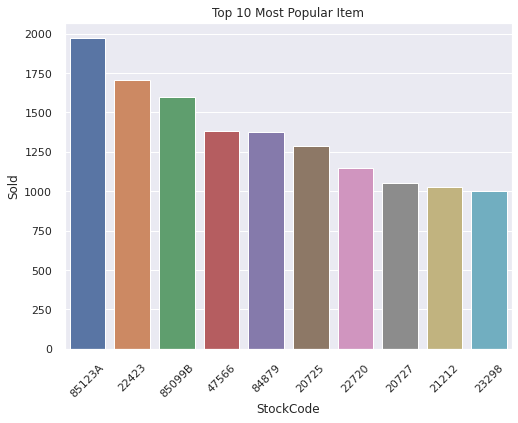

In [61]:
ax = sns.barplot(data = item_dist[:10], x = 'StockCode', y = 'Sold')
plt.xticks(rotation = 45)
plt.title('Top 10 Most Popular Item')

Item Category

In [62]:
txt = ''

for i in range(len(item_dist)):
  product = item_dist.iloc[i]['Description']
  sold = item_dist.iloc[i]['Sold']

  for j in range(sold):
    txt = txt + ' ' + product

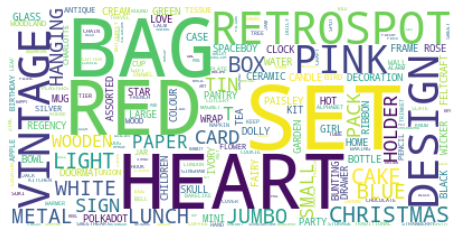

In [63]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(txt)

plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

From here, we can see that the products of the following categories are more likely to attract customers:
1. Heart
2. Vintage
3. Bag
4. Retrospot
5. Cake

with Red, Pink, and Blue colours.

### Weekly Transaction Trend

Number of Transactions & Gross Revenue

In [64]:
# Number of Transactions
weekly_trans = data.groupby(pd.Grouper(freq = 'W', key = 'InvoiceDate'))['InvoiceNo'].count()

weekly_trans = pd.DataFrame(weekly_trans).reset_index()

weekly_trans = weekly_trans.rename(columns = {'InvoiceNo': 'Transactions'})

weekly_trans.head(5)

,InvoiceDate,Transactions
0,2010-12-05,7362
1,2010-12-12,9201
2,2010-12-19,6903
3,2010-12-26,1754
4,2011-01-02,0


In [65]:
# Gross Revenue
weekly_grv = data.copy()

weekly_grv['Revenue'] = data['TotalQuantity'] * data['UnitPrice']

weekly_grv = weekly_grv.groupby(pd.Grouper(freq = 'W', key = 'InvoiceDate'))['UnitPrice'].sum()

weekly_grv = pd.DataFrame(weekly_grv).reset_index()

weekly_grv = weekly_grv.rename(columns = {'UnitPrice': 'GrossRevenueValue'})

weekly_grv.head(5)

,InvoiceDate,GrossRevenueValue
0,2010-12-05,22661.26
1,2010-12-12,27898.57
2,2010-12-19,21861.87
3,2010-12-26,5466.06
4,2011-01-02,0.00


Text(0.5, 1.0, 'Weekly Transactions and GRV')

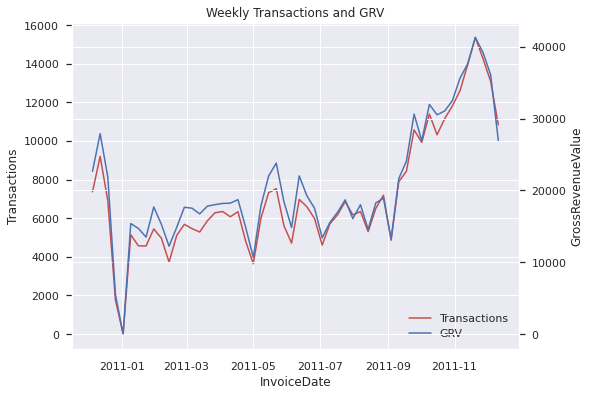

In [66]:
fig, ax = plt.subplots()

fig = sns.lineplot(data = weekly_trans, x = 'InvoiceDate', y = 'Transactions', color = 'r', label = 'Transactions')
ax2 = plt.twinx()
fig2 = sns.lineplot(data = weekly_grv, x = 'InvoiceDate', y = 'GrossRevenueValue', ax = ax2, label = 'GRV')

h1, l1 = fig.get_legend_handles_labels()
h2, l2 = fig2.get_legend_handles_labels()
ax.legend(loc = 'lower right', 
          handles = h1 + h2, 
          labels = l1 + l2)
ax2.get_legend().remove()

plt.title('Weekly Transactions and GRV')

In [67]:
(weekly_trans['Transactions'].values[-1] - weekly_trans['Transactions'].values[0])/weekly_trans['Transactions'].values[0]*100

47.13393099701168

In [68]:
(weekly_grv['GrossRevenueValue'].values[-1] - weekly_grv['GrossRevenueValue'].values[0])/weekly_grv['GrossRevenueValue'].values[0]*100

18.969289439333913

### Customer Base

In [69]:
cust_base = data.copy()

cust_base['Revenue'] = data['TotalQuantity'] * data['UnitPrice']

cust_base = cust_base.groupby(['Country'])[['InvoiceNo', 'Revenue']].agg({'InvoiceNo': 'count',
                                                                          'Revenue': 'sum'}).reset_index()

cust_base = cust_base.rename(columns = {'InvoiceNo': 'Transactions',
                                        'Revenue': 'GrossRevenueValue'})

cust_base

,Country,Transactions,GrossRevenueValue
0,Australia,1182,138171.31
1,Austria,384,8742.68
2,Bahrain,17,548.40
3,Belgium,1935,36927.34
4,Brazil,32,1143.60
5,Canada,150,3115.44
6,Channel Islands,743,20007.44
7,Cyprus,597,13254.69
8,Czech Republic,24,786.74
9,Denmark,367,18211.34


Notice that there is an Unspecified country. But since we are going to search for the customer base and doing customer segmentation, we will remove this data.

In [70]:
cust_base = cust_base.loc[cust_base['Country'] != 'Unspecified']

cust_base = cust_base.sort_values(by = ['Transactions', 'GrossRevenueValue'], ascending = False).reset_index(drop = True)

cust_base

,Country,Transactions,GrossRevenueValue
0,United Kingdom,344210,7265862.23
1,Germany,8635,205569.89
2,France,7999,183891.68
3,EIRE,7127,257296.56
4,Spain,2402,55725.11
5,Netherlands,2326,283889.34
6,Belgium,1935,36927.34
7,Switzerland,1811,52441.95
8,Portugal,1401,26707.95
9,Australia,1182,138171.31


## Modelling

For this customer segmentation, we will use an aggregated data based on the CustomerID.

In [71]:
cust_segment = data.copy()

cust_segment['Nominal'] = cust_segment['TotalQuantity'] * cust_segment['UnitPrice']

cust_segment = cust_segment.groupby(['CustomerID', 'Country'])[['InvoiceNo', 'Nominal']].agg({'InvoiceNo': 'count',
                                                                                              'Nominal': 'sum'}).reset_index()

cust_segment = cust_segment.rename(columns = {'InvoiceNo': 'Transactions'})

### Data Preparation

Label Encoding

In [72]:
# We will copy the dataset so that we can check later on what value each label refer to
cust_segment_copy = cust_segment[['Country', 'Transactions', 'Nominal']]

label_encoder = LabelEncoder()

for col in cust_segment_copy.columns:
    if cust_segment_copy[col].dtypes == 'object':
        cust_segment_copy[col] = label_encoder.fit_transform(cust_segment_copy[col])

<ipython-input-72-aac25d58e740>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_segment_copy[col] = label_encoder.fit_transform(cust_segment_copy[col])


Scaling

In [73]:
scaler = StandardScaler()
scaler.fit(cust_segment_copy)
scaled_cust_segment = pd.DataFrame(scaler.transform(cust_segment_copy),
                                   columns = cust_segment_copy.columns )

In [74]:
scaled_cust_segment

,Country,Transactions,Nominal
0,0.294798,-0.397327,8.448057
1,-2.742139,0.420103,0.257682
2,-3.381494,-0.279906,-0.065192
3,-2.422461,-0.076677,-0.062909
4,-1.463429,-0.329584,-0.193638
...,...,...,...
4338,0.294798,-0.356681,-0.206428
4339,0.294798,-0.370230,-0.217642
4340,0.294798,-0.347649,-0.206714
4341,0.294798,2.700779,0.008052


### Clustering

Elbow Method

Elbow Method to determine the number of clusters to be formed:


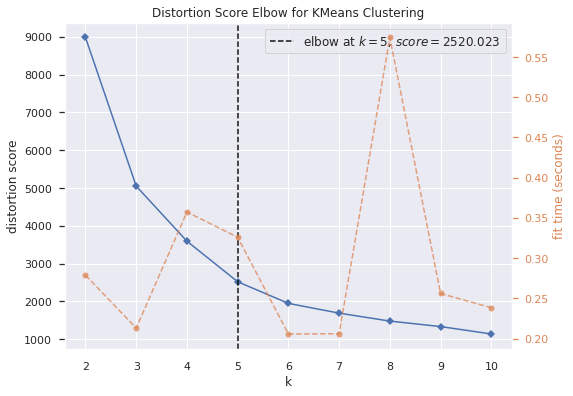

In [75]:
# Quick examination of elbow method to find numbers of clusters to make

print('Elbow Method to determine the number of clusters to be formed:')

Elbow_M = KElbowVisualizer(KMeans(), 
                           k = 10, 
                           random_state = 3425)
Elbow_M.fit(scaled_cust_segment)
Elbow_M.show()

Agglomerative Clustering

In [76]:
# Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters = 5)

# Fit model and predict clusters
yhat_AC = AC.fit_predict(scaled_cust_segment)
scaled_cust_segment['Clusters'] = yhat_AC

# Adding the Clusters feature to the orignal dataframe.
cust_segment['Clusters'] = yhat_AC
cust_segment_copy['Clusters'] = yhat_AC

<ipython-input-76-5e2155b7e3ba>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_segment_copy['Clusters'] = yhat_AC


Plotting

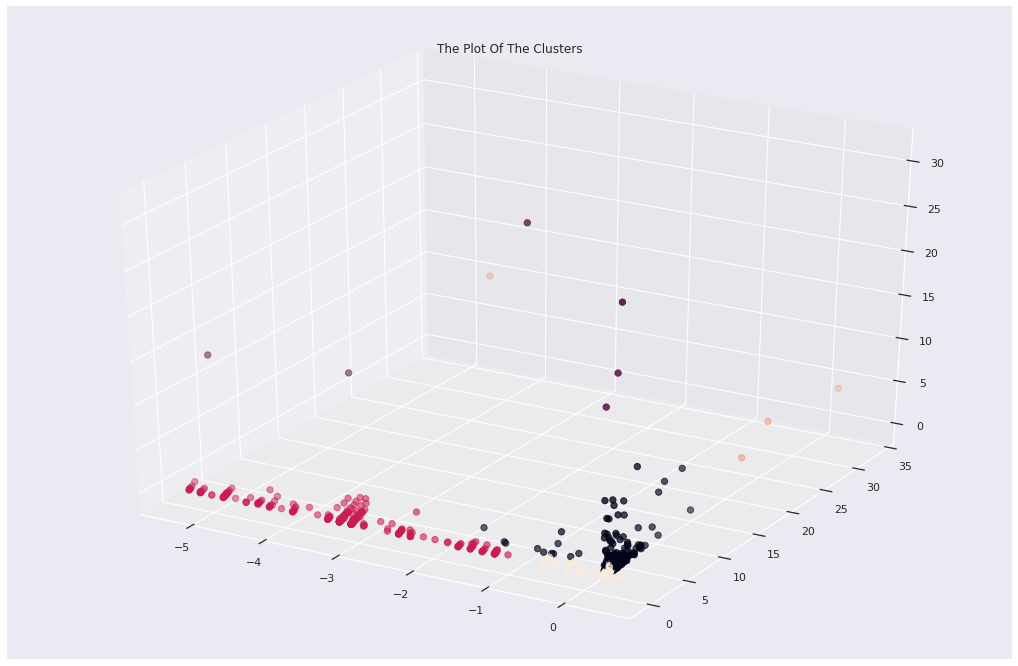

In [77]:
# Plotting the clusters

x = scaled_cust_segment['Country']
y = scaled_cust_segment['Transactions']
z = scaled_cust_segment['Nominal']

fig = plt.figure(figsize = (18,12))

ax = plt.subplot(111, 
                 projection = '3d', 
                 label = "bla")

ax.scatter(x, y, z, 
           s = 40, 
           c = scaled_cust_segment["Clusters"], 
           marker = 'o')

ax.set_title("The Plot Of The Clusters")
plt.show()

Model Evaluation

Text(0.5, 1.0, 'Cluster distributions')

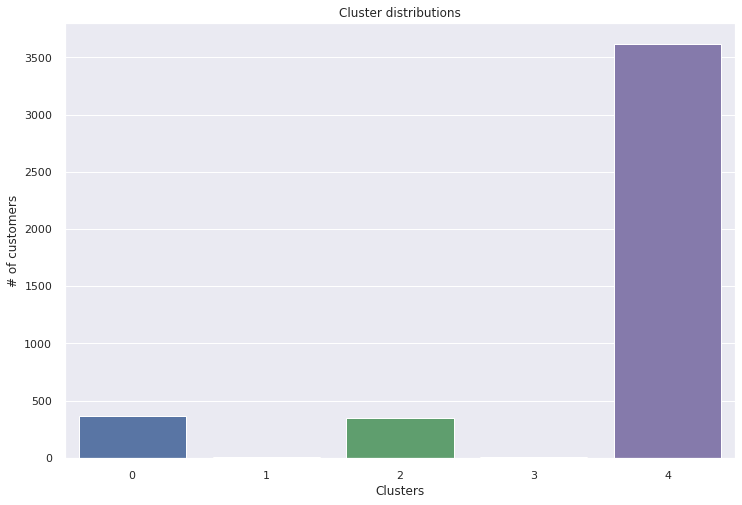

In [78]:
plt.figure(figsize = (12,8))

sns.countplot(data = cust_segment, x = 'Clusters')

plt.xlabel('Clusters')
plt.ylabel('# of customers')
plt.title('Cluster distributions')

### Pattern Recognition

In [79]:
cust_segment

,CustomerID,Country,Transactions,Nominal,Clusters
0,0,United Kingdom,1,77183.60,0
1,1,Iceland,182,4310.00,2
2,2,Finland,27,1437.24,2
3,3,Italy,72,1457.55,2
4,4,Norway,16,294.40,2
...,...,...,...,...,...
4338,4330,United Kingdom,10,180.60,4
4339,4331,United Kingdom,7,80.82,4
4340,4332,United Kingdom,12,178.05,4
4341,4333,United Kingdom,687,2088.93,0


Cluster 1

In [80]:
cluster_1 = cust_segment.loc[cust_segment['Clusters'] == 1]

cluster_1.describe()

,CustomerID,Transactions,Nominal,Clusters
count,6.000000,6.000000,6.000000,6.0
mean,2335.000000,821.666667,190518.795000,1.0
std,1579.472064,765.026971,67720.900708,0.0
min,55.000000,3.000000,116729.630000,1.0
25%,1423.000000,359.750000,135541.522500,1.0
50%,2348.500000,573.000000,181511.645000,1.0
75%,3546.250000,1214.500000,243380.672500,1.0
max,4198.000000,2064.000000,279138.020000,1.0


Cluster 2

In [81]:
cluster_2 = cust_segment.loc[cust_segment['Clusters'] == 2]

cluster_2.describe()

,CustomerID,Transactions,Nominal,Clusters
count,348.000000,348.000000,348.000000,348.0
mean,363.011494,74.873563,1873.789885,2.0
std,599.844081,89.990496,2751.309029,0.0
min,1.000000,1.000000,45.000000,2.0
25%,108.750000,20.000000,392.450000,2.0
50%,218.500000,41.000000,878.215000,2.0
75%,312.250000,96.250000,2328.695000,2.0
max,4010.000000,616.000000,21429.390000,2.0


Cluster 3

In [82]:
cluster_3 = cust_segment.loc[cust_segment['Clusters'] == 3]

cluster_3.describe()

,CustomerID,Transactions,Nominal,Clusters
count,4.000000,4.000000,4.00000,4.0
mean,1876.000000,5605.750000,65704.79750,3.0
std,1558.988561,1355.135756,47825.42498,0.0
min,326.000000,4273.000000,32317.32000,3.0
25%,1049.000000,4889.500000,38805.12000,3.0
50%,1585.000000,5340.500000,47113.07500,3.0
75%,2412.000000,6056.750000,74012.75250,3.0
max,4008.000000,7469.000000,136275.72000,3.0


Cluster 4

In [83]:
cluster_4 = cust_segment.loc[cust_segment['Clusters'] == 4]

cluster_4.describe()

,CustomerID,Transactions,Nominal,Clusters
count,3620.000000,3620.000000,3620.000000,3620.0
mean,2321.754144,53.581215,937.822541,4.0
std,1168.342899,52.038264,1046.813126,0.0
min,7.000000,1.000000,0.000000,4.0
25%,1316.750000,15.000000,273.600000,4.0
50%,2330.500000,34.000000,570.730000,4.0
75%,3329.250000,76.000000,1208.835000,4.0
max,4334.000000,240.000000,10254.180000,4.0


Cluster 5

In [84]:
cluster_5 = cust_segment.loc[cust_segment['Clusters'] == 5]

cluster_5.describe()

,CustomerID,Transactions,Nominal,Clusters
count,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN


# Summary

1. Recommendation System model was built using the **.........** method, and was able to achieve **0.12687346417761125 RMSE**
2. Followings are the **top 5 most popular products**:
  - White Hanging Heart T-Light Holder	(2028 sold)
  - Regency Cakestand 3 Tier (1724 sold)
  - Jumbo Bag Red Retrospot	(1618 sold)
  - Assorted Colour Bird Ornament	(1408 sold)
  - Party Bunting (1397 sold)
3. Products of the following categories are **more likely** to **attract** customers:
  - Heart
  - Vintage
  - Bag
  - Retrospot
  - Cake
  
  with **Red**, **Pink**, and **Blue** colours.
4. The weekly # of transactions and Gross Revenue Value (GPV) have an **increment trend**, with an increment of **+45.07%** and **+17.89%** overall, respectively.
5. Followings are the **top 3 countries** with the **most # of transactions**:
  - United Kingdom (475309 transactions)
  - Germany	(8635 transactions)
  - France	(8065 transactions)
6. Followings are the **top 3 countries** with the **highest GPV**:
  - United Kingdom (\$ 8747561.66)
  - Netherlands	(\$ 283889.34)
  - Ireland	(\$ 271164.30)